In [53]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


env = gym.make("Blackjack-v1", sab=True)

In [54]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [55]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=0.9
)

In [56]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/1000000 [00:00<?, ?it/s]

 23%|██▎       | 230042/1000000 [00:46<02:35, 4937.12it/s]

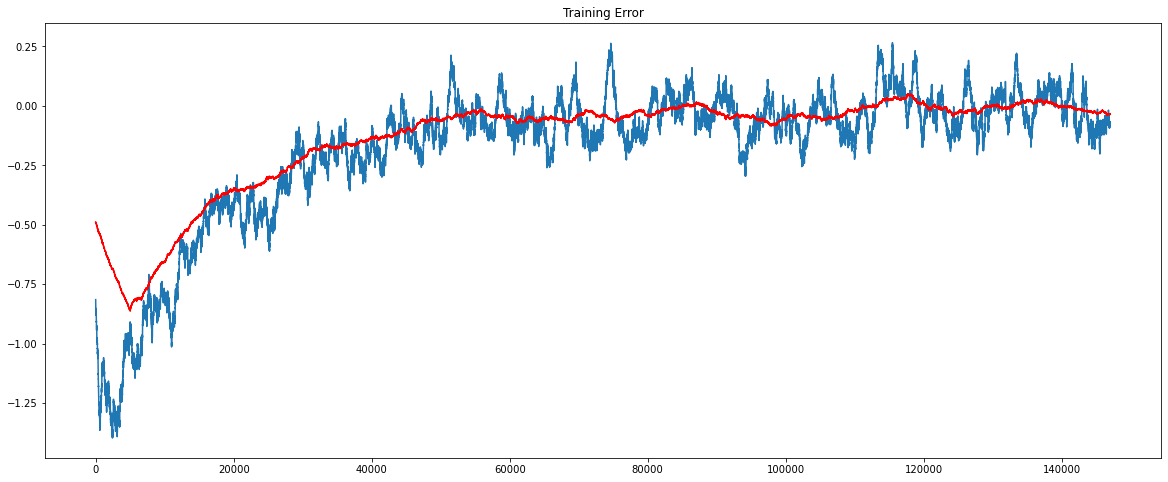

In [28]:
plt.title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(1250), mode="same") / 250
)
plt.plot(training_error_moving_average)
plt.rcParams["figure.figsize"] = (20,8)
training_error_moving_average_smooth = (
    np.convolve(np.array(agent.training_error), np.ones(10000), mode="same") / 2500
)
plt.plot(training_error_moving_average_smooth, 'r')
plt.show()

### Zobrazowanie polityki modelu

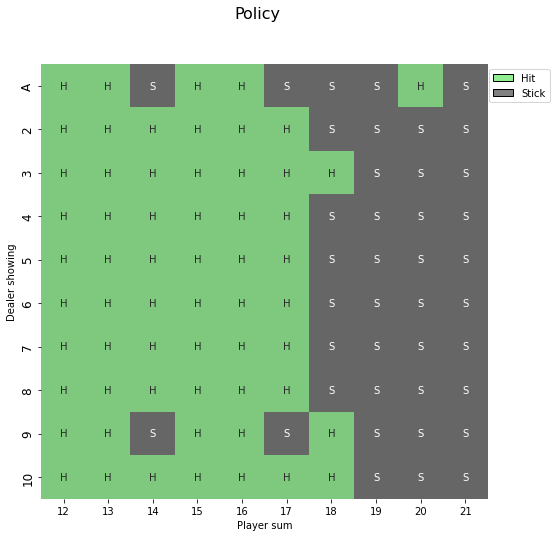

In [52]:

state_value = defaultdict(float)
policy = defaultdict(int)
for obs, action_values in agent.q_values.items():
    state_value[obs] = float(np.max(action_values))
    policy[obs] = int(np.argmax(action_values))

player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11))

policy_grid = np.apply_along_axis(
    lambda obs: policy[(obs[0], obs[1], True)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)
policy_grid_str = []
for row in policy_grid:
    policy_grid_str.append([])
    for value in row:
        policy_grid_str[-1].append("H" if value else "S")
    
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Policy", fontsize=16)
    
fig.add_subplot(1, 1, 1)
ax = sns.heatmap(policy_grid, annot=np.array(policy_grid_str), fmt="", cmap="Accent_r", cbar=False)
ax.set_xlabel("Player sum")
ax.set_ylabel("Dealer showing")
ax.set_xticklabels(range(12, 22))
ax.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

legend_elements = [
    Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.15 , 1))
   
plt.show()